In [1]:
import pandas as pd
df = pd.read_csv('Exercise2BusData.csv')

In [2]:
df = df.iloc[:1000]
df = df.drop(['Arrival_time','Stop_id','Bus_id','Line_id'], axis=1)

In [3]:
corr_matrix = df.corr()
corr_matrix['Arrival_delay'].sort_values(ascending=False)

Arrival_delay            1.000000
Upstream_stop_delay      0.993908
Dwell_time               0.222777
Recurrent_delay          0.161830
Scheduled_travel_time    0.117362
Name: Arrival_delay, dtype: float64

In [5]:
# split train and test sets

x = df.drop(['Arrival_delay'], axis=1)
y = df['Arrival_delay']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [7]:
# grid search

from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param_grid = {
    'n_estimators': [100, 200, 300],   # Number of boosting stages
    'learning_rate': [0.01, 0.1, 0.2], 
    'max_depth': [3, 4, 5],            # Maximum depth of each tree
    'subsample': [0.8, 0.9, 1.0],      # Subsample ratio of the training instances
}

gbr = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)
print("Best Score:", grid_search.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best Score: -377.3734034412911


In [16]:
# training and predicting

model = xgb.XGBRegressor(n_estimators=best_params['n_estimators'], 
                                  learning_rate=best_params['learning_rate'], 
                                  max_depth=best_params['max_depth'], 
                                  subsample=best_params['subsample'])

# Define the evaluation set, using the training data itself to track train loss
eval_set = [(X_train, y_train)]

model.fit(X_train, y_train, eval_set=eval_set, verbose=False)
y_pred = model.predict(X_test)

In [17]:
# evaluation

from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 10.017773695141077
Mean Squared Error: 186.67852934978825
Root Mean Squared Error: 13.663035144132078
R-squared: 0.9924922585487366


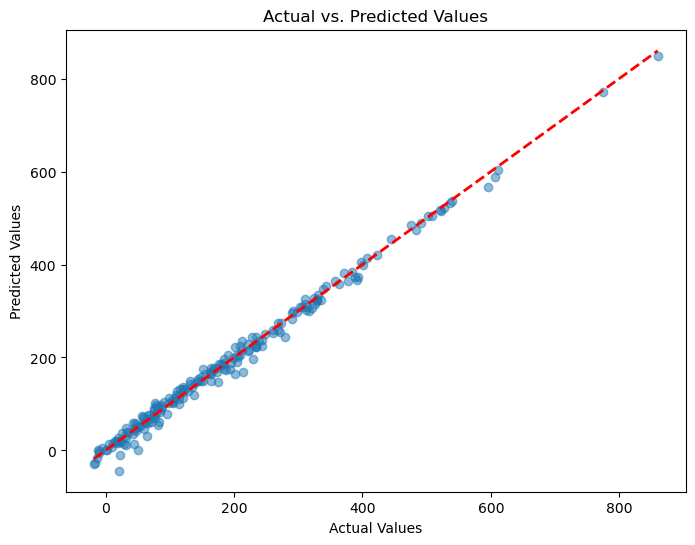

In [11]:
import matplotlib.pyplot as plt

# y_test contains the actual target values for the test dataset
# y_pred contains the predicted values for the test dataset

# Create a scatter plot to visualize the relationship
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)  # Plot actual vs. predicted values

# Add labels and title
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line for reference (perfect predictions)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)

# Show the plot
plt.show()

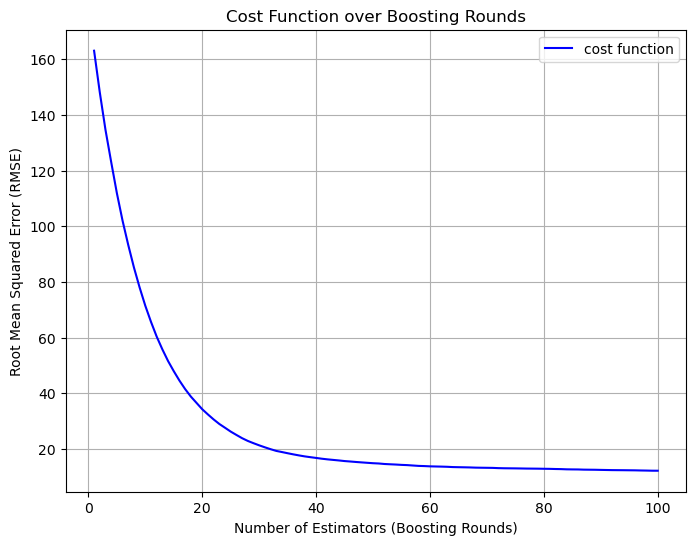

In [21]:
# objective function

# Extract training loss (RMSE) after each iteration
train_loss = model.evals_result()['validation_0']['rmse']

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='cost function', color='blue')
plt.xlabel('Number of Estimators (Boosting Rounds)')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Cost Function over Boosting Rounds')
plt.legend()
plt.grid(True)
plt.show()